# JetsonCar Dreamnet Autoencoder 

Reduces the images taken by the jetsoncar in order to speed up training of supervised, unsupervised, self-supervised learning algorithms

In [1]:
import tensorflow as tf
print(tf.__version__)
tf.config.experimental.list_physical_devices('GPU') # If device does not show and using conda env with tensorflow-gpu then try restarting computer

2.0.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

(480, 848, 3)


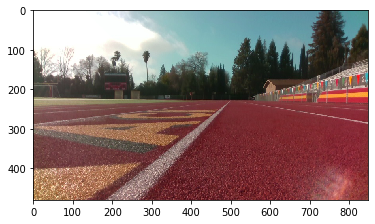

In [2]:
# verify the image data directory
import os
data_directory = "/media/michael/BigMemory/datasets/jetsoncar/autoencoder_dataset"
os.listdir(data_directory)[:10]

import matplotlib.pyplot as plt
img = plt.imread(os.path.join(data_directory + "/color_images", os.listdir(data_directory + "/color_images")[0]))
print(img.shape)
plt.imshow(img)

Found 15965 images belonging to 1 classes.
Found 3991 images belonging to 1 classes.
(128, 224, 3)


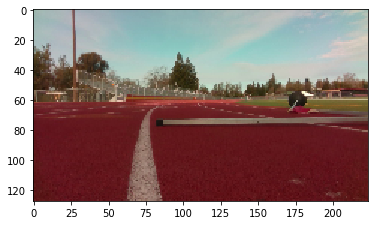

In [3]:
import numpy as np

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255, horizontal_flip=True, validation_split=0.2)
train_image_generator = datagen.flow_from_directory(data_directory, target_size=(128,224), batch_size=8, subset='training', class_mode="input")
validation_image_generator = datagen.flow_from_directory(data_directory, target_size=(128,224), batch_size=8, subset='validation', class_mode="input")

img = train_image_generator.next()[0][0]
print(img.shape)
plt.imshow(np.squeeze(img))

# Define the model for autoencoding the images

In [4]:
#shape = (height, width, channel)
shape = (128, 224, 3)

model = tf.keras.models.Sequential([
    # encoder part of the model
    tf.keras.layers.Input(shape=shape),
    tf.keras.layers.Conv2D(64, (3,3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2), padding='same'),
    tf.keras.layers.Conv2D(32, (3,3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2), padding='same'),
    tf.keras.layers.Conv2D(16, (3,3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2), padding='same'),
    tf.keras.layers.Conv2D(4, (3,3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2), padding='same', name="enc"),

    
    # decoder part of the model
    tf.keras.layers.Conv2D(4, (3,3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(16, (3,3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.UpSampling2D((2,2)),
#     tf.keras.layers.Conv2D(shape[2], (3,3), activation="linear", padding='same', name='dec')
    tf.keras.layers.Conv2D(shape[2], (3,3), activation=tf.nn.sigmoid, padding='same', name='dec')
])

# model.compile(optimizer="adam", loss="mse", metrics=['acc'])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 224, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 224, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 112, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 112, 32)       18464     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 112, 32)       128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 56, 16)        4

## Train the model using the generator

In [5]:
import datetime
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
print("To view tensorboard please run `tensorboard --logdir logs/fit` in the code directory from the terminal with deeplearning env active")

model.fit_generator(train_image_generator,
          steps_per_epoch=1000, # batch size
          epochs=20,
          validation_data=validation_image_generator,
          validation_steps=10,
          callbacks=[tensorboard_callback])

To view tensorboard please run `tensorboard --logdir logs/fit` in the code directory from the terminal with deeplearning env active
Epoch 1/20
1000/1000 [==============================] - 66s 66ms/step - loss: 0.5445 - acc: 0.0272 - val_loss: 0.5713 - val_acc: 0.0114
Epoch 2/20
1000/1000 [==============================] - 66s 66ms/step - loss: 0.5342 - acc: 0.0265 - val_loss: 0.5654 - val_acc: 0.0114
Epoch 3/20
1000/1000 [==============================] - 65s 65ms/step - loss: 0.5321 - acc: 0.0268 - val_loss: 0.5646 - val_acc: 0.0114
Epoch 4/20
1000/1000 [==============================] - 65s 65ms/step - loss: 0.5298 - acc: 0.0271 - val_loss: 0.5608 - val_acc: 0.0114
Epoch 5/20
1000/1000 [==============================] - 65s 65ms/step - loss: 0.5289 - acc: 0.0270 - val_loss: 0.5601 - val_acc: 0.0114
Epoch 6/20
1000/1000 [==============================] - 65s 65ms/step - loss: 0.5292 - acc: 0.0269 - val_loss: 0.5608 - val_acc: 0.0115
Epoch 7/20
1000/1000 [==============================

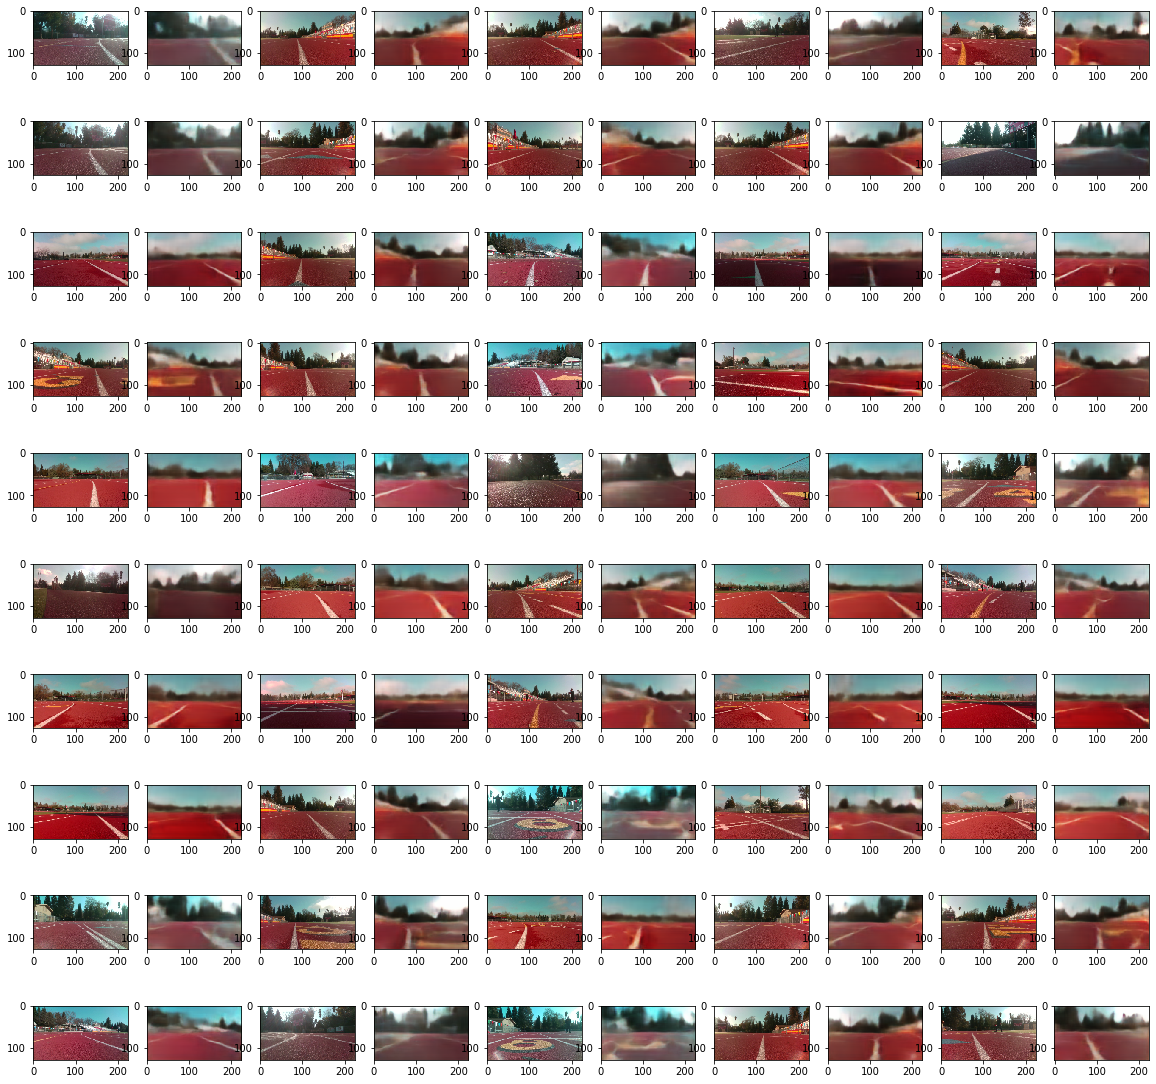

In [6]:
cols, rows = 10, 10
fig=plt.figure(figsize=(20, 20))
for i in range(1, cols*rows +1 ,2):
    test_img = validation_image_generator.next()[0][0]
    img = np.squeeze(test_img)
    reconstructed_img = np.squeeze(model.predict(np.expand_dims(test_img, axis=0)))
    
    # Plot the input and output images side by side
    fig.add_subplot(rows, cols, i)
    plt.imshow(img)
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(reconstructed_img)


plt.show()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 224, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 224, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 112, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 112, 32)       18464     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 112, 32)       128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 56, 32)        0   

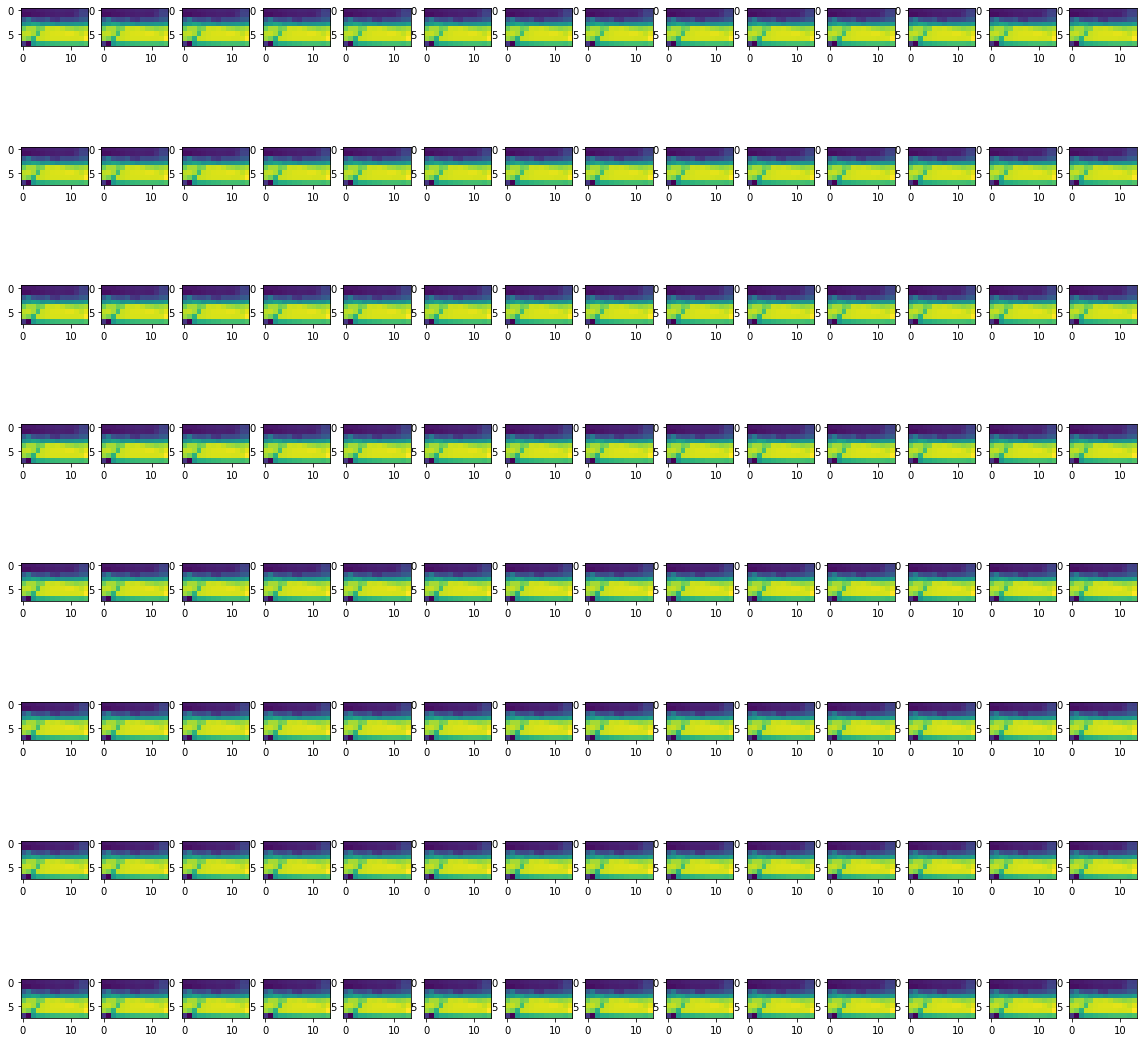

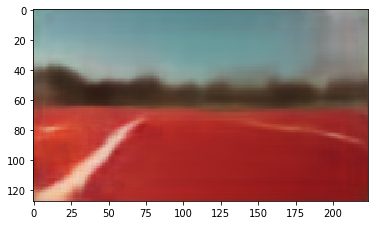

In [8]:
encoder = tf.keras.models.Model(inputs=model.inputs, outputs=model.get_layer("enc").output, name="encoder")
encoder.summary()
print()

# create the decoder
# this is more difficult than the encoder since we cant remove the top layers from a preexisting model. Rather we make a new model and transfer the wieghts
decoder = tf.keras.models.Sequential([
    # decoder part of the model
    tf.keras.layers.Input((encoder.output.shape[1],encoder.output.shape[2],encoder.output.shape[3])), # make sure this line is here to be able to trasnfer weights
    tf.keras.layers.Conv2D(4, (3,3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(16, (3,3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.UpSampling2D((2,2)),
#     tf.keras.layers.Conv2D(shape[2], (3,3), activation="linear", padding='same', name='dec')
    tf.keras.layers.Conv2D(shape[2], (3,3), activation=tf.nn.sigmoid, padding='same', name='dec')
], name="decoder")
decoder.summary()

# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer#set_weights
for i, layer in enumerate(decoder.layers):
    layer.set_weights(model.layers[12+i].get_weights()) # 12 is the size of the encoder minus the input later

# Test the encoder and print encoding
test_img = validation_image_generator.next()[0][0]
encoding = encoder.predict(np.expand_dims(test_img, axis=0))
print("\nPrinting the encoder output")
fig = plt.figure(figsize=(20,20))
rows = 8
cols = 14
for i in range(rows*cols):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(np.squeeze(encoding)[:,:,0])
plt.show()

# Test the decoder and show the decoding
img = decoder.predict(encoding)
plt.imshow(np.squeeze(img))

In [9]:
decoder.save("dreamnet_decoder")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: dreamnet_decoder/assets


In [10]:
encoder.save("dreamnet_encoder")

INFO:tensorflow:Assets written to: dreamnet_encoder/assets


In [11]:
model.save("dreamnet_full_encoder")

INFO:tensorflow:Assets written to: dreamnet_full_encoder/assets


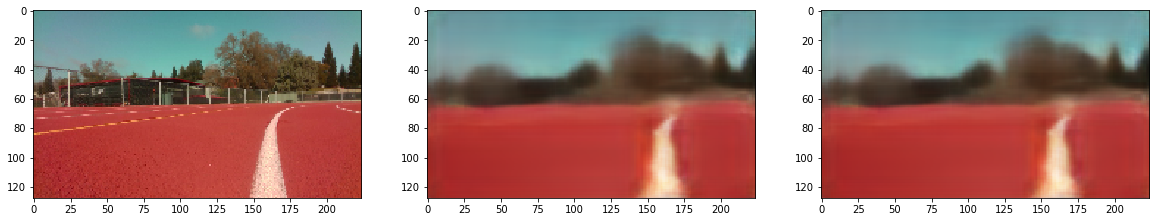

In [12]:
loaded_model = tf.keras.models.load_model("dreamnet_full_encoder")
loaded_encoder = tf.keras.models.load_model("dreamnet_encoder")
loaded_decoder = tf.keras.models.load_model("dreamnet_decoder")
test_img = validation_image_generator.next()[0][0]
img = loaded_model.predict(np.expand_dims(test_img, axis=0)) # for testing full model
encoding = loaded_encoder.predict(np.expand_dims(test_img, axis=0))
decoding = loaded_decoder.predict(encoding)

fig = plt.figure(figsize=(20,20))

fig.add_subplot(1, 3, 1)
plt.imshow(np.squeeze(test_img))

fig.add_subplot(1, 3, 2)
plt.imshow(np.squeeze(img))

fig.add_subplot(1, 3, 3)
plt.imshow(np.squeeze(decoding))